Load Julia packages (libraries) needed

In [1]:
using TuringModels
using Optim, Turing, Flux.Tracker
gr(size=(600,300));

In [2]:
Turing.setadbackend(:reverse_diff);
Turing.turnprogress(false);

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /Users/rob/.julia/packages/Turing/UXxKz/src/Turing.jl:24


### snippet 2.8t

Define the data

In [3]:
k = 6; n = 9;

Define the model

In [4]:
@model globe_toss(n, k) = begin
  theta ~ Beta(1, 1) # prior
  k ~ Binomial(n, theta) # model
  return k, theta
end;

Compute the "maximum_a_posteriori" value

Set search bounds

In [5]:
lb = [0.0]; ub = [1.0];

Create (compile) the model

In [6]:
model = globe_toss(n, k);

Use Turing mcmc

In [7]:
chn = sample(model, NUTS(2000, 200, 0.65));

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/support/hmc_core.jl:240
[NUTS{Turing.Core.FluxTrackerAD,Union{}}] found initial ϵ: 1.6
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/support/hmc_core.jl:235
┌ Warning: 30.233553739684915 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/adapt/stepsize.jl:96
┌ Warning: 7.889099062323837 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/adapt/stepsize.jl:96
┌ Warning: 14.646706811472448 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/adapt/stepsize.jl:96
┌ Warning: 7.45573609006478 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/adapt/

Look at the generated draws (in chn)

In [8]:
describe(chn)

Iterations = 1:2000
Thinning interval = 1
Chains = 1
Samples per chain = 2000

Empirical Posterior Estimates:
              Mean          SD         Naive SE        MCSE         ESS   
  lf_num  0.0000000000 0.0000000000 0.00000000000 0.00000000000        NaN
 elapsed  0.0005684173 0.0063118704 0.00014113771 0.00020772872  923.25794
 epsilon  1.0264169559 0.3340457072 0.00746948909 0.01845236987  327.72343
   theta  0.6374231276 0.1361615866 0.00304466564 0.00345071564 1557.00807
      lp -3.2930428100 0.9078108068 0.02029926675 0.03147222835  832.02372
eval_num  6.6930000000 3.7008916898 0.08275445396 0.16259264565  518.09685
  lf_eps  1.0264169559 0.3340457072 0.00746948909 0.01845236987  327.72343

Quantiles:
              2.5%          25.0%         50.0%         75.0%          97.5%    
  lf_num  0.00000000000  0.0000000000  0.000000000  0.00000000000  0.00000000000
 elapsed  0.00016431537  0.0001764105  0.000233734  0.00045175175  0.00087731927
 epsilon  0.54178007382  1.00000000

Look at the mean and sd

In [9]:
println("\ntheta = $(mean_and_std(chn[:theta][201:2000]))\n")


theta = (0.635170633898351, 0.13397115660859585)



Fix the inclusion of adaptation samples

In [10]:
chn2 = MCMCChain.Chains(chn.value[201:2000,:,:], names=chn.names)

Object of type "Chains{Float64}"

Iterations = 1:1800
Thinning interval = 1
Chains = 1
Samples per chain = 1800

Union{Missing, Float64}[0.0 0.000364633 … 4.0 1.0; 0.0 0.000200388 … 4.0 1.0; … ; 0.0 0.000167563 … 4.0 1.0; 0.0 0.000427577 … 10.0 1.0]

Look at the proper draws (in corrected chn2)

In [11]:
describe(chn2)

Iterations = 1:1800
Thinning interval = 1
Chains = 1
Samples per chain = 1800

Empirical Posterior Estimates:
              Mean            SD         Naive SE         MCSE         ESS   
  lf_num  0.00000000000 0.00000000000 0.000000000000 0.000000000000       NaN
 elapsed  0.00035659777 0.00051873043 0.000012226593 0.000017358918  892.9726
 epsilon  1.00000000000 0.00000000000 0.000000000000 0.000000000000       NaN
   theta  0.63517063390 0.13397115661 0.003157730444 0.003400843399 1551.8486
      lp -3.25654195017 0.66684346679 0.015717651245 0.015120645625 1800.0000
eval_num  6.48666666667 2.95657660002 0.069687178766 0.087611740044 1138.8163
  lf_eps  1.00000000000 0.00000000000 0.000000000000 0.000000000000       NaN

Quantiles:
              2.5%           25.0%         50.0%          75.0%          97.5%    
  lf_num  0.00000000000  0.00000000000  0.0000000000  0.00000000000  0.00000000000
 elapsed  0.00016367512  0.00017577875  0.0002308895  0.00044934025  0.00082200005
 epsi

Compute at hpd region

In [12]:
bnds = MCMCChain.hpd(chn2[:, 4, :], alpha=0.06);

analytical calculation

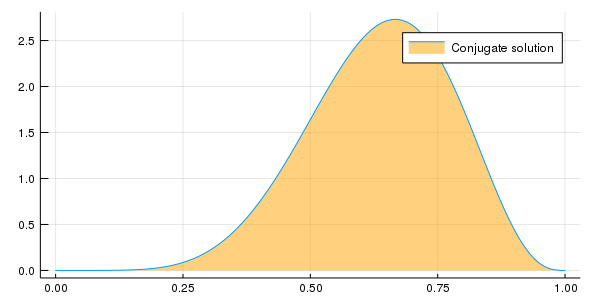

In [13]:
w = 6; n = 9; x = 0:0.01:1
plot( x, pdf.(Beta( w+1 , n-w+1 ) , x ), fill=(0, .5,:orange), lab="Conjugate solution")

quadratic approximation

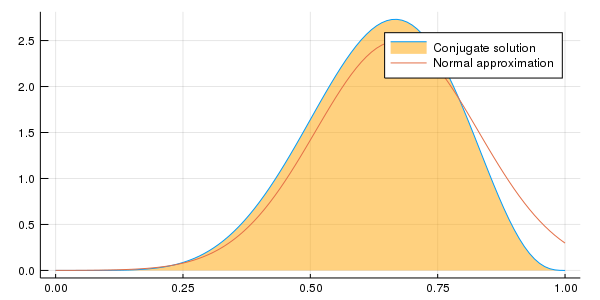

In [14]:
plot!( x, pdf.(Normal( 0.67 , 0.16 ) , x ), lab="Normal approximation")

Turing Chain &  89%hpd region boundaries

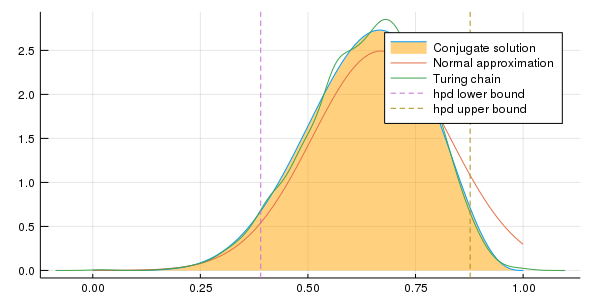

In [15]:
#tmp = convert(Array{Float64,3}, chn.value[:, 4, :])
#draws = reshape(tmp, (size(tmp, 1)*size(tmp, 3)),)
density!(chn.value[:, 4, 1], lab="Turing chain")
vline!([bnds.value[1]], line=:dash, lab="hpd lower bound")
vline!([bnds.value[2]], line=:dash, lab="hpd upper bound")

Show hpd region

In [16]:
println("hpd bounds = $bnds\n")

hpd bounds =        94% Lower  94% Upper
theta 0.39026614 0.87691282





End of `clip_08t.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*